# INTRO

In this python notebook, we analyze the data throught tests. We Try to understand if the the 

In [84]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from tools_analysis import *

### Definition of input folder

In [85]:
folder_path = "../study"
stats_path = folder_path + "/stats"

### Concatenation of all patient's metrics

In [88]:
## Read the list of subjects and for each subject do the tractography
dest_success = folder_path + "/subjects/subj_list.json"
with open(dest_success, 'r') as file:
    patient_list = json.load(file)
del file

dfs = []
for p_code in patient_list:
    metric_folder = "%s/subjects/%s/dMRI/microstructure/%s_metrics.csv" % (folder_path, p_code, p_code)
    if not os.path.exists(metric_folder):
        print(metric_folder, "doesn't exists")
        continue
    dfs.append(pd.read_csv(metric_folder))
    del metric_folder
del p_code

df = pd.concat(dfs, ignore_index=True)
del dfs

"""
Check that there are the expected number of columns:
25 metrics, 4 measure for each metric, 5 tracts, 6 roi, 2 means right and left
For each tract we measure the number of tracts found (5*2)
For each ROI we measure the volume in mm^3 (6*2)
The ID
"""
assert df.columns.size == 25 * 4 * (5+6) * 2 + (5*2) + (6*2) + 1

info_df = pd.read_csv(stats_path + "/info.csv")
non_dMRIfeatures = info_df.columns.drop(["ID"])

df = pd.merge(info_df, df, on="ID")
del info_df

if not os.path.isdir(stats_path):
    os.mkdir(stats_path)

df.to_csv("%s/dataset.csv" % stats_path, index=False)

../study/subjects/sub67_E1/dMRI/microstructure/sub67_E1_metrics.csv doesn't exists


# Exploration

# Features names:
```json
metrics = {
    "dti" : ["FA", "AD", "RD", "MD"],
    "noddi" : ["icvf", "odi", "fbundle", "fextra", "fintra", "fiso" ],
    "diamond" : ["wFA", "wMD", "wAD", "wRD", "frac_c0", "frac_c1", "frac_csf", "frac_ctot"],
    "mf" : ["fvf_f0", "fvf_f1", "wfvf", "frac_f0", "frac_f1", "frac_csf", "frac_ftot"]
}

masks_name = [
    "thalamus",
    "hippocampus",
    "amygdala",
    "accumbens",
    "putamen",
    "pallidum",

    "fornix",
    "inf-longi-fasci",
    "sup-longi-fasci",
    "thalamus-AntCingCtx",
    "thalamus-Insula",
]
```

They are composed in the following manner:

[right|left]-[mask_name]\_[metrics]\_[mean|std|skew|kurt]

Here the explanation of some features:

NR-RP/R:

- NR-RP/R == 0 => Non Responder
- NR-RP/R == 1 => Partial responder or Responder

NR-RP-R:

- NR-RP-R == 0 => Non Responder
- NR-RP-R == 1 => Partial Responder
- NR-RP-R == 2 => Responder

epilepsy_type:

- epilepsy_type == 1 => Generalized
- epilepsy_type == 2 => Focal

# Analysis on only epileptic patiens without personal data

In [89]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset.csv" % stats_path, index_col="ID")
print(df.shape)
# Removing the healty subjects
df.dropna(axis=0, how="any", inplace=True) 
print(df.shape)

col_dMRI = df.filter(regex=r'mean|std|skew|kurt').columns
col_nTract = df.filter(regex=r'nTracts').columns
col_voxVol = df.filter(regex=r'voxVol').columns
col_cont = ["age", "therapy_duration", "epilepsy_onset_age", "epilepsy_duration", *col_nTract, *col_voxVol, *col_dMRI]
col_cat = ["sex", "AEDs", "benzo", "epilepsy_type"]
col_interest = [*col_nTract, *col_voxVol, *col_dMRI]
df.head()

(36, 2232)
(19, 2232)


,resp,respPart,age,therapy_duration,sex,AEDs,benzo,epilepsy_onset_age,epilepsy_type,epilepsy_duration,...,right-hippocampus_frac_ftot_skew,right-hippocampus_frac_ftot_kurt,right-amygdala_frac_ftot_mean,right-amygdala_frac_ftot_std,right-amygdala_frac_ftot_skew,right-amygdala_frac_ftot_kurt,right-accumbens-area_frac_ftot_mean,right-accumbens-area_frac_ftot_std,right-accumbens-area_frac_ftot_skew,right-accumbens-area_frac_ftot_kurt
ID,,,,,,,,,,,,,,,,,,,,,
VNSLC_01,1.0,2.0,36.0,93.0,0.0,3.0,0.0,5.0,0.0,31.0,...,-1.613743,2.210564,0.862931,0.138549,-2.572578,7.602861,0.896009,0.118009,-2.097275,5.037863
VNSLC_02,1.0,2.0,29.0,13.0,1.0,2.0,0.0,14.0,0.0,15.0,...,-1.668391,1.102442,0.781193,0.295028,-1.837274,2.051685,0.912331,0.114470,-7.386770,57.562770
VNSLC_03,1.0,2.0,65.0,234.0,0.0,3.0,0.0,15.0,0.0,50.0,...,-1.266501,0.288610,0.704799,0.271525,-1.459608,1.303677,0.876784,0.045763,0.679643,2.295736
VNSLC_04,1.0,2.0,34.0,11.0,1.0,2.0,0.0,8.0,1.0,26.0,...,-1.594550,1.063834,0.862251,0.197580,-3.203897,10.726188,0.923108,0.135780,-5.445194,33.609681
VNSLC_06,0.0,0.0,62.0,136.0,1.0,2.0,0.0,36.0,1.0,26.0,...,-1.570091,1.272044,0.844713,0.242636,-2.837769,7.093954,0.950262,0.067657,-2.450565,9.954374


In [4]:
print(df.value_counts("resp"))
print(df.value_counts("respPart"))

resp
1.0    12
0.0     7
Name: count, dtype: int64
respPart
2.0    8
0.0    7
1.0    4
Name: count, dtype: int64


In our case we have few examples (patients), and so the model will not be so accurate. Then the difference between patients responders and not is different, so our model will be bias influenced.

While if we see the number of samples between responders, partial and not, the number of samples for each class is almost equilibrate.

icsf is the thresholded f_intra, so we expect some correlation between the two metrics

In [99]:
from sklearn.preprocessing import RobustScaler

right-inf-longi-fasci_nTracts       39892.118264
left-thalamus-Insula_nTracts        28881.247581
right-thalamus-Insula_nTracts       23317.898349
left-inf-longi-fasci_nTracts        22853.608433
right-sup-longi-fasci_nTracts       11357.144095
left-sup-longi-fasci_nTracts         7738.173066
left-thalamus-AntCingCtx_nTracts     1218.268986
right-thalamus-proper_voxVol         1108.261781
right-putamen_voxVol                  995.038613
right-hippocampus_voxVol              785.453931
dtype: float64

# Simple Exploratory Data Analysis

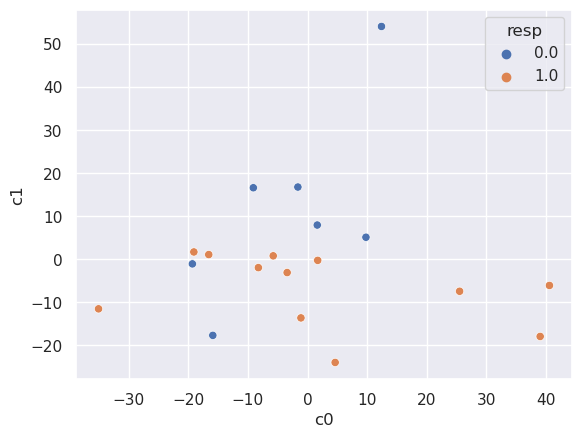

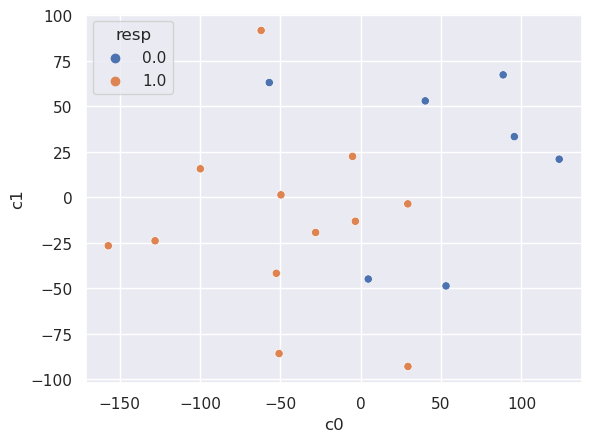

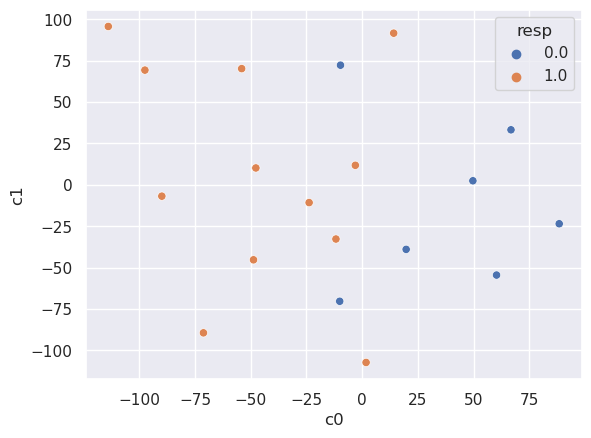

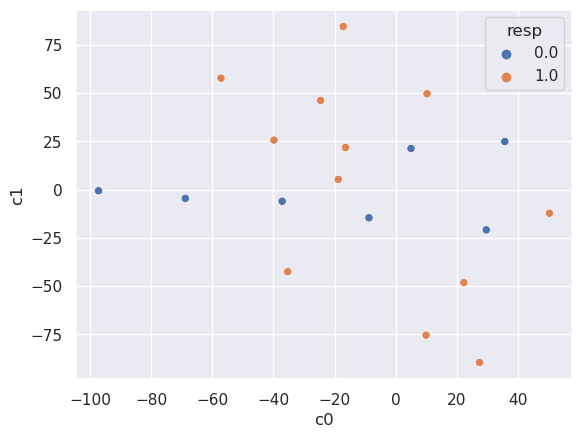

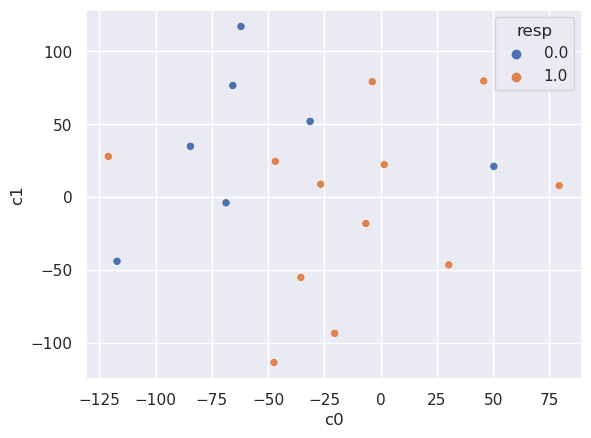

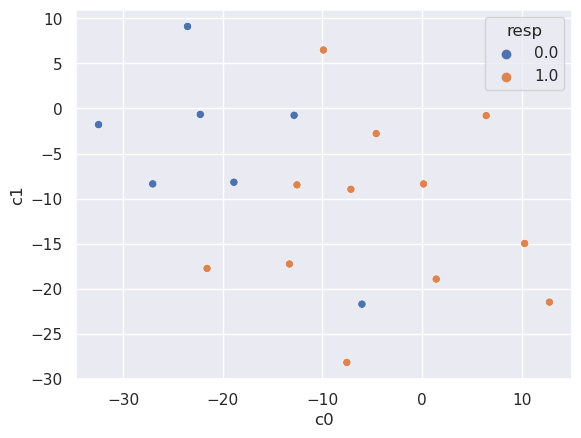

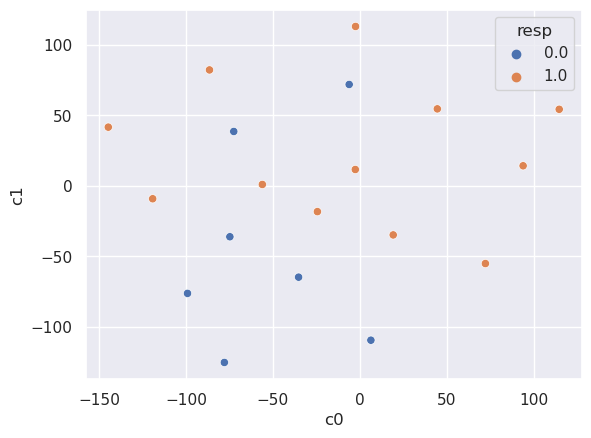

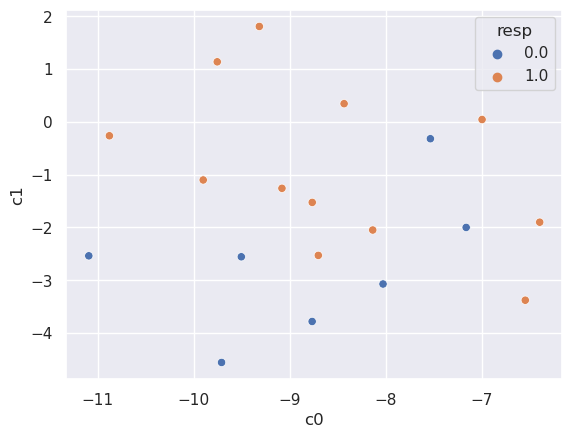

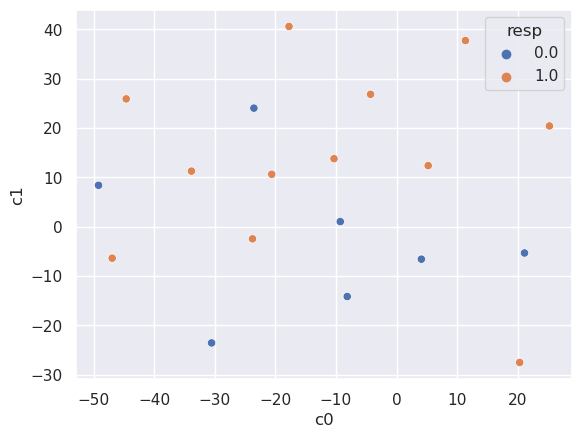

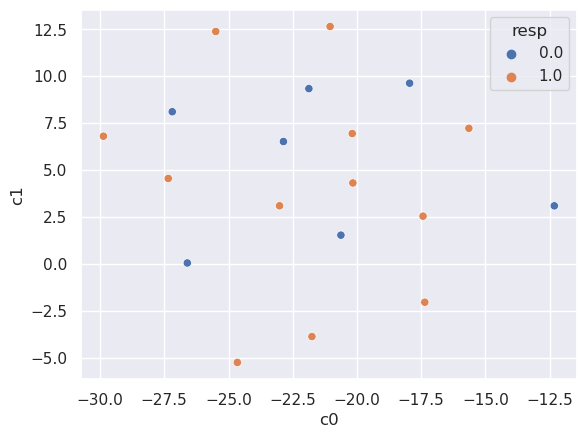

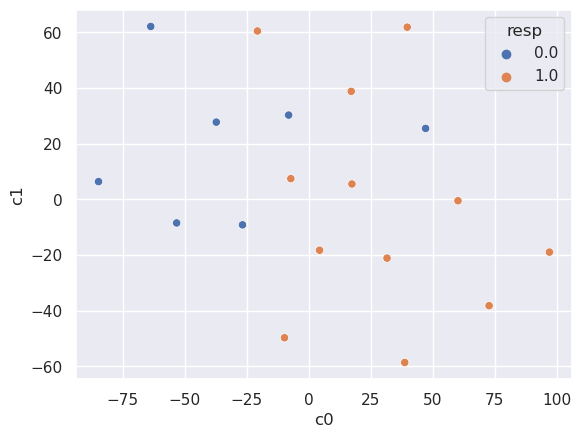

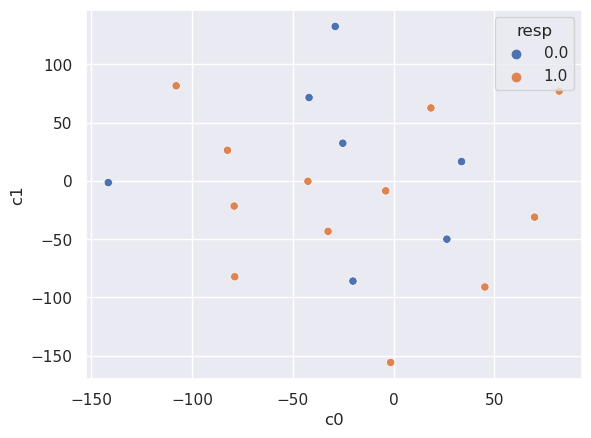

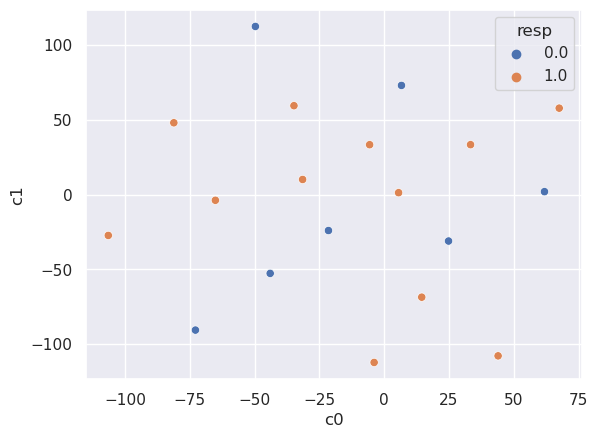

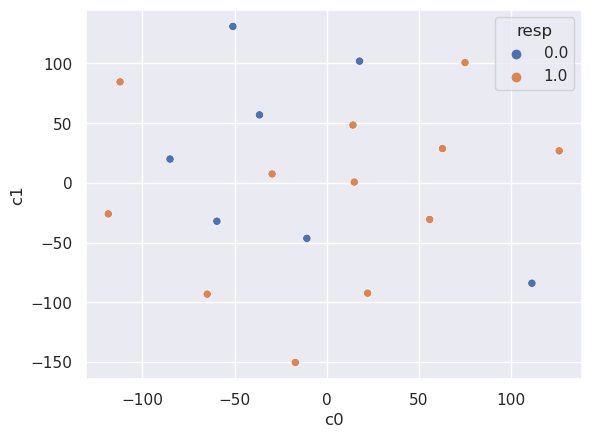

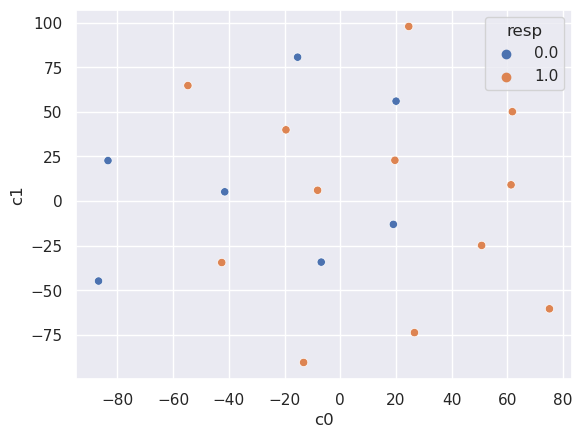

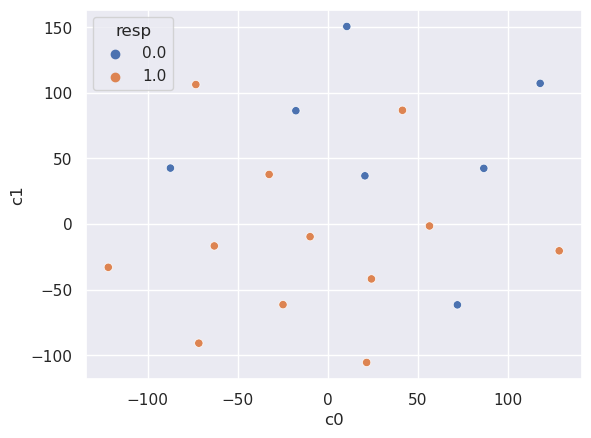

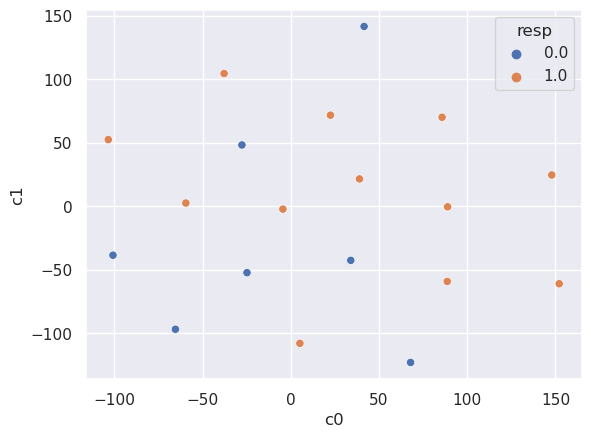

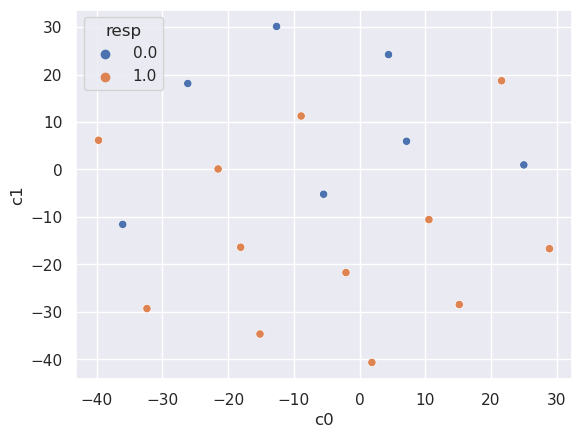

In [90]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()

X = scaler.fit_transform(df[df.filter(regex=r'mean|std|skew|kurt').columns])

pca = PCA(
    n_components=2,
    svd_solver="full",
)
Y_pca = pd.DataFrame(pca.fit_transform(X), index=df.index, columns=["c0", "c1"])
Y_pca = pd.concat([Y_pca, df["resp"]], axis=1)

sns.scatterplot(Y_pca, x="c0", y="c1", hue="resp")

for perplexity in range(2, 19):

    tSNE = TSNE(
        n_components=2,
        perplexity=perplexity, # to change
        learning_rate="auto", # epslon
        n_iter=5000, # per essere sicuro delle convergenza
        #n_iter_without_progress=3000, # per stopparlo prima
        #init="pca",
        method="exact", # it's slowert but out dataset is small so we can affort it
        n_jobs=-1, # run in parallel
    )
    Y_tSNE = pd.DataFrame(tSNE.fit_transform(X),index=df.index, columns=["c0", "c1"])
    Y_tSNE = pd.concat([Y_tSNE, df["resp"]], axis=1)

    plt.figure()
    sns.scatterplot(Y_tSNE, x="c0", y="c1", hue="resp")

<Axes: xlabel='resp', ylabel='right-fornix_icvf_mean'>

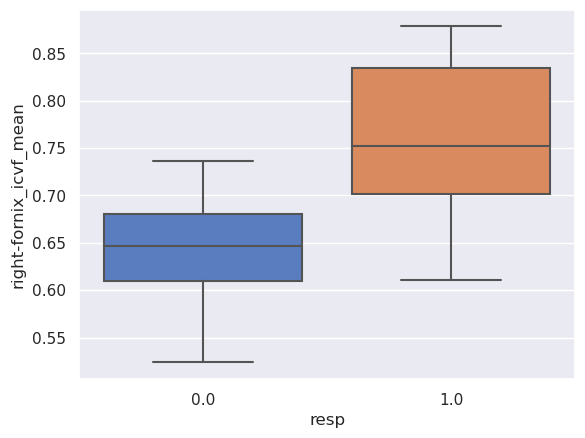

In [73]:
sns.boxplot(df, y="right-fornix_icvf_mean", x="resp")

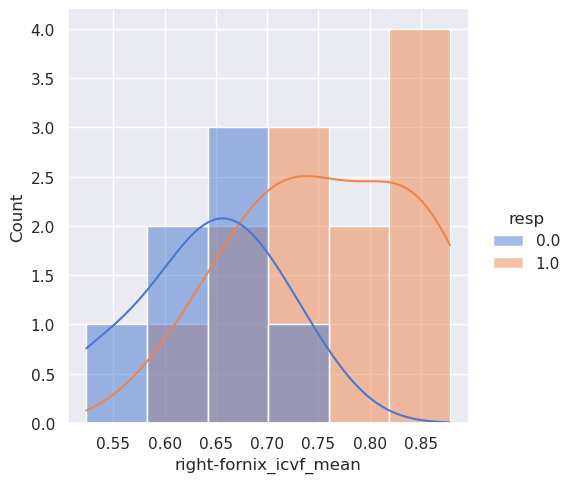

In [74]:
sns.displot(df, x="right-fornix_icvf_mean", hue="resp", kde=True)

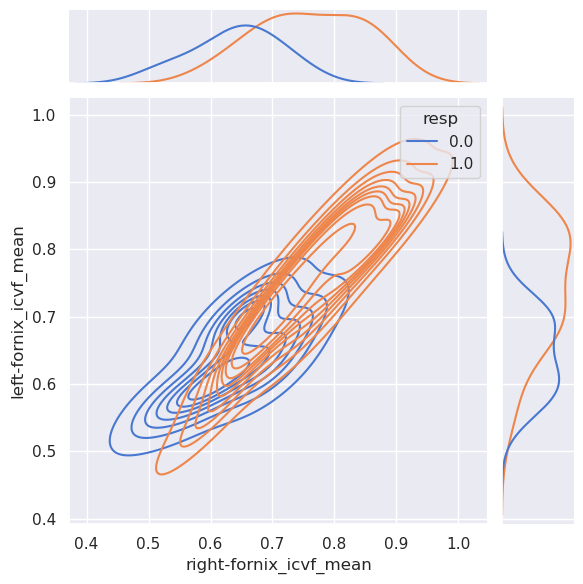

In [75]:
sns.jointplot(
    data=df,
    x='right-fornix_icvf_mean', y='left-fornix_icvf_mean', hue="resp",
    kind="kde"
)

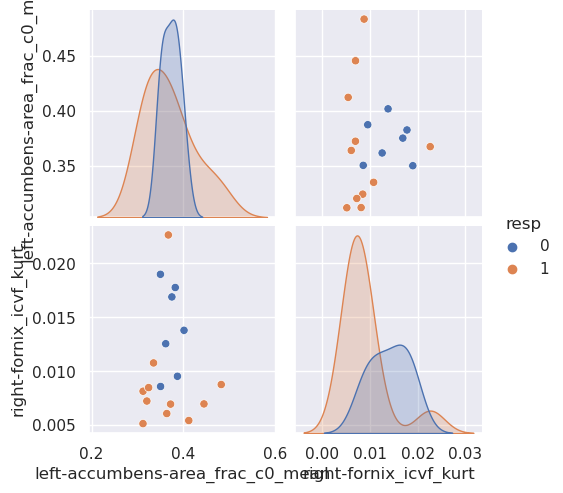

In [ ]:
toPlot = ['left-accumbens-area_frac_c0_mean', 'right-fornix_icvf_kurt']
sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

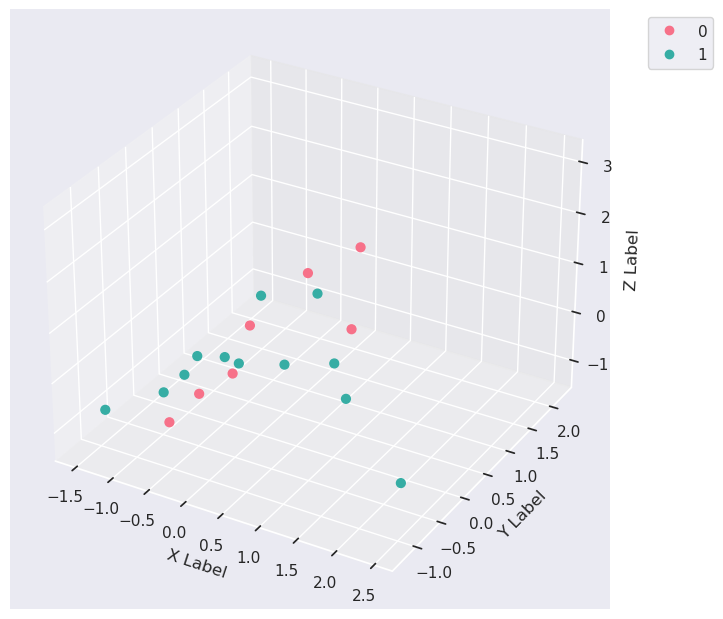

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

a = df
features = ['left-inf-longi-fasci_nTracts', 'left-thalamus-Insula_nTracts', 'right-inf-longi-fasci_nTracts']
x = a[features[0]]
y = a[features[1]]
z = a[features[2]]
labs = a["resp"]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=labs, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Scaling

In [91]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[col_interest], df["resp"], test_size=1/3, random_state=7, shuffle=True, stratify=df["resp"])

for scaler in [None, StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer()]:
    print(scaler.__class__.__name__)
    
    X_train_scaled = X_train
    X_test_scaled = X_test
    if scaler is not None:
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

    run_log_reg(X_train_scaled, X_test_scaled, y_train, y_test, verbose=True)


NoneType


F1: 0.092 | Pr: 0.612 | Re: 0.990 | AUC: 0.575 | Accuracy: 0.451 

StandardScaler
F1: 0.271 | Pr: 0.673 | Re: 0.858 | AUC: 0.600 | Accuracy: 0.457 

RobustScaler
F1: 0.407 | Pr: 0.579 | Re: 0.993 | AUC: 0.486 | Accuracy: 0.459 

MinMaxScaler
F1: 0.006 | Pr: 0.571 | Re: 1.000 | AUC: 0.500 | Accuracy: 0.429 

Normalizer
F1: 0.729 | Pr: 0.770 | Re: 0.998 | AUC: 0.717 | Accuracy: 0.679 



# Feature Weights

In [81]:
import eli5
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

col_noskurt_noskew = df.filter(regex=r'mean|std').columns
col_noskurt_noskew = [*col_noskurt_noskew]

X_train, X_test, y_train, y_test = train_test_split(df[col_noskurt_noskew], df["resp"], test_size=1/3, random_state=7, shuffle=True, stratify=df["resp"])

clf = LogisticRegressionCV(
    cv=StratifiedShuffleSplit(n_splits=100, test_size=1/3, random_state=7),
    penalty="l2",
    n_jobs=-1,
    scoring="f1",
    solver="liblinear"
)

pipe = Pipeline([
    ("scaler", Normalizer()),
    ("clf", clf)
])

pipe.fit(X_train, y_train)

eli5.show_weights(clf, feature_names=col_noskurt_noskew, target_names=["nonResp", "resp"])

In [83]:
import shap
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(df[col_interest], df["resp"], test_size=1/3, random_state=7, shuffle=True, stratify=df["resp"])

clf = LogisticRegressionCV(
    cv=StratifiedShuffleSplit(n_splits=100, test_size=1/3, random_state=7),
    penalty="l2",
    n_jobs=-1,
    scoring="f1",
    solver="liblinear"
)

pipe = Pipeline([
    ("scaler", Normalizer()),
    ("clf", clf)
])

pipe.fit(X_train, y_train)

explainer = shap.Explainer(pipe.predict, X_test)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values)

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 4093!

In [59]:
import shap
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[col_interest], df["resp"], test_size=1/3, random_state=7, shuffle=True, stratify=df["resp"])

log_reg = SGDClassifier(loss = 'log_loss', n_jobs = -1, alpha = 1e-4, penalty="l2")
log_reg.fit(X_train, y_train)

explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer.shap_values(X_test)
shap.initjs()
ind = 0
shap.force_plot(explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:], feature_names = col_interest)

# Managing of NaN values

There are different method to handle the missing values:
- Deleting the rows
- Imputing the missing values with the mean/median
- Predicting the missing values (Machine Learning with sklearn) https://scikit-learn.org/stable/modules/impute.html

For the ROI taken from tracts we will use a prediction method to impute the NaN values

In [61]:
(df[col_nTract] == 0).sum(axis=1)
(df[col_nTract] == 0).sum(axis=0)
df[col_nTract].loc[(df[col_nTract] <= 1).sum(axis=1) > 0, (df[col_nTract] <= 1).sum(axis=0) > 0]

,left-fornix_nTracts,right-fornix_nTracts,right-thalamus-AntCingCtx_nTracts,left-thalamus-AntCingCtx_nTracts
ID,,,,
VNSLC_03,0,0,362,1
VNSLC_17,35,5,0,167
VNSLC_19,1497,44,0,9


#### Mean imputation

Show the means, to understand if the probabilistic imputation is better than the mean/median.

In [7]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy="mean")

X_train = pd.DataFrame(imp.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test), index=X_test.index, columns=X_test.columns)

#### Probabilistic imputation

Here we use a lasso regression to estimate the values of the missing values.

Lasso is a reguralized linear regrassion in wich the alpha term weight the regularization. 
The main property of Lasso is the possibility of have a weight of 0 in features that are not used in the regression. It is exactly our case, where fore example featurese like FA, wFA and fvf_tot are high correlated. while others aren't.

the results of obtained by this imputation with lasso are very similar to the results from the mean imputation.

In [371]:
## FIRST VERSION 

from sklearn.experimental import enable_iterative_imputer # useful to enable the experimental IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso

imp = IterativeImputer(
    estimator=Lasso(alpha=50), 
    max_iter=10, 
    missing_values=np.nan,
    verbose=2,
    )

df_prob = pd.DataFrame(imp.fit_transform(X), index=X.index, columns=X.columns)

[IterativeImputer] Completing matrix with shape (19, 1817)
[IterativeImputer] Ending imputation round 1/10, elapsed time 6.66
[IterativeImputer] Change: 2.2512855777121227e-15, scaled tolerance: 0.004219568867593187 
[IterativeImputer] Early stopping criterion reached.


Indeed, what I said before is false, bacause the features of FA wFA anf fvf_tot are high correlated in the same region of the brain. But, since that the region for which we are predicting the value is missing, other regions where used to estimate the values. And so, if different regions are plotted, there isn't a correlation between them.

To solve this problem, a solution would be to extract each missing feature and for each of them train a regression model fitted with the remains feature. the remains feature are selected through a feature selection model.

In [ ]:
## MORE ACCURATE VERSION
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, f_regression, RFECV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA, KernelPCA

col_nan = X.columns[X.isna().any()]
idx_nan = X.index[X.isna().any(axis=1)]
X_nan = X[col_nan]
X_compl = X.drop(col_nan, axis=1)

imputed = pd.DataFrame()

ensemleModel = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_features="log2",
    max_depth=10, # usually from 8 to 32
    warm_start=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
)

# feature Extraction
## PCA
pca = pd.DataFrame(PCA(n_components=10).fit_transform(X_compl), index=X_compl.index, columns=["PC%d" % i for i in range(10)])
X_compl = pd.concat([X_compl, pca], axis=1)
## kPCA
kernel_pca = pd.DataFrame( KernelPCA(
    n_components=10,
    kernel="rbf",
    gamma=1,
    n_jobs=-1
).fit_transform(X_compl), index=X_compl.index, columns=["kPC%d" % i for i in range(10)])
X_compl = pd.concat([X_compl, kernel_pca], axis=1)

for f_name, x in X_nan.items():
    print("Imputing for", f_name)

    # Remove the nan samples for the feature selection
    X_train = X_compl.drop(idx_nan, axis=0)
    x_train = x.drop(idx_nan, axis=0)
    sel_col = X_train.columns
    X_filtr = pd.DataFrame(X_train)

    # feature selection 
    ## Filter the best 10%
    def myScoreFunc(X, y):
        mi_score = mutual_info_regression(X, y)
        f_score = f_regression(X, y)[0]
        return mi_score + f_score
    
    selector = SelectPercentile(myScoreFunc).fit(X_train, x_train)
    sel_col = X_train.columns[selector.get_support()]
    X_filtr = selector.transform(X_train)

    print("Filtered %d features" % (sel_col.size))

    ## Embedded method select 7 best features
    selector = RFECV(
        estimator=ensemleModel,
        min_features_to_select=1,
        cv=2,
        step=0.25,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    ).fit(X_filtr, x_train)
    sel_col = sel_col[selector.get_support()]
    X_filtr = selector.transform(X_filtr)

    print("Selected %d features" % (sel_col.size))
    print(sel_col)

    # imputation of values
    X_imp = pd.concat([X_compl[sel_col], x], axis=1)

    impMod = IterativeImputer(
        estimator=MLPRegressor(
            hidden_layer_sizes=(sel_col.size//2, 9, 5),
            solver="lbfgs", # for small datasets,
            alpha=1, # regularization term
            learning_rate="adaptive",
            max_iter=10000,
            tol=1e-3
        ), 
        # estimator=ensemleModel,
        max_iter=20, 
        tol=1e-2,
        missing_values=np.nan,
        verbose=2,
    ).fit(X_imp)

    curr_imp = pd.DataFrame(impMod.transform(X_imp), index=X_imp.index, columns=X_imp.columns)    
    imputed = pd.concat([imputed, curr_imp[f_name]])

X = pd.concat([X_compl, imputed])

This Last one is a good predictor but take too time, and so unsifible.
A intermedian model can be as the first one, without feature selection. And usign a boosting model to find the best feature and so doing a good approximation.

In [ ]:
from sklearn.experimental import enable_iterative_imputer # useful to enable the experimental IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor

# # feature Extraction
# ## PCA
# pca = pd.DataFrame(PCA(n_components=10).fit_transform(X_compl), index=X_compl.index, columns=["PC%d" % i for i in range(10)])
# X_compl = pd.concat([X_compl, pca], axis=1)
# ## kPCA
# kernel_pca = pd.DataFrame( KernelPCA(
#     n_components=10,
#     kernel="rbf",
#     gamma=1,
#     n_jobs=-1
# ).fit_transform(X_compl), index=X_compl.index, columns=["kPC%d" % i for i in range(10)])
# X_compl = pd.concat([X_compl, kernel_pca], axis=1)

ensemleModel = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_features="log2",
    max_depth=10, # usually from 8 to 32
    warm_start=True,
    n_iter_no_change=10,
    tol=1e-4,
    validation_fraction=0.2,
)

imp = IterativeImputer(
    estimator=ensemleModel, 
    max_iter=50,
    verbose=2,
)

X_train = pd.DataFrame(imp.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test), index=X_test.index, columns=X_test.columns)

## Deleting Features

Since we can't do speculations and prediction on the biological data [Ask to Nicolas and Benoit], we have decided to remove the feature or the columns that contains NaN values

In [7]:
# X_train = X_train.dropna(axis=0, how="any")
X_train = X_train.dropna(axis=1, how="any")

y_train = y_train[X_train.index]

In [10]:
X_train.shape

(15, 1738)

### Analysis over the number of streamline for tract

We have generated 2M of seed to generate the streamlines for each ROI tract. So, there are some patients have 4k streamlines for the fornix and some that have 0 streamlines.

This is a value that depends on the physical structure of the tract in the patient. A small value means a damaged or missing structure, because wan't found any streamline that compose the ROI.

# Visualization

## TSNE meanifold

<Axes: xlabel='c0', ylabel='c1'>

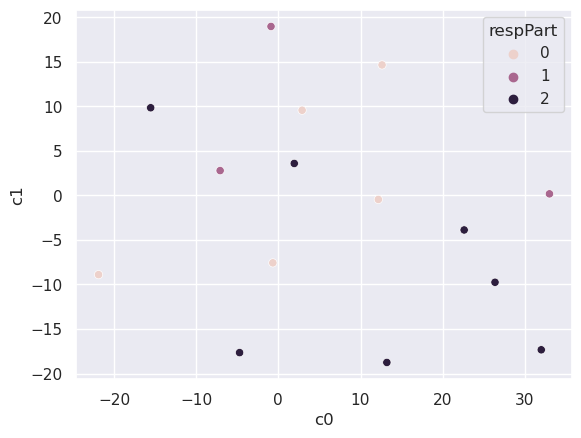

In [12]:
from sklearn.manifold import TSNE

X_embedded = TSNE(
    n_components=2,
    perplexity=3, # try different values till the number of samples
    early_exaggeration=3,
    init="random",
    n_jobs=-1
).fit_transform(X_train)
X_embedded = pd.DataFrame(X_embedded, index=X_train.index, columns=["c%d" % i for i in range(2)])
df_embedded = pd.concat([X_embedded, y_train],axis=1)

sns.scatterplot(df_embedded, x="c0", y="c1", hue=df["respPart"])

## PCA

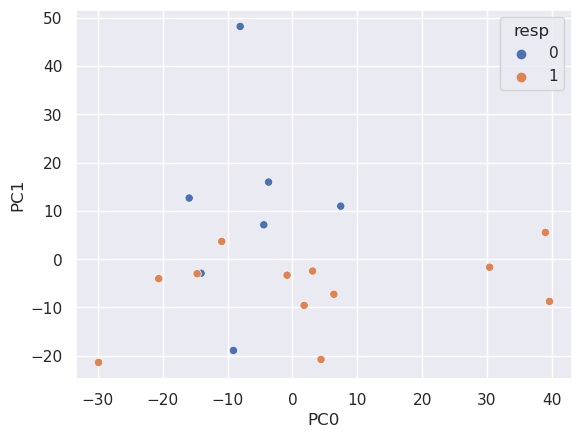

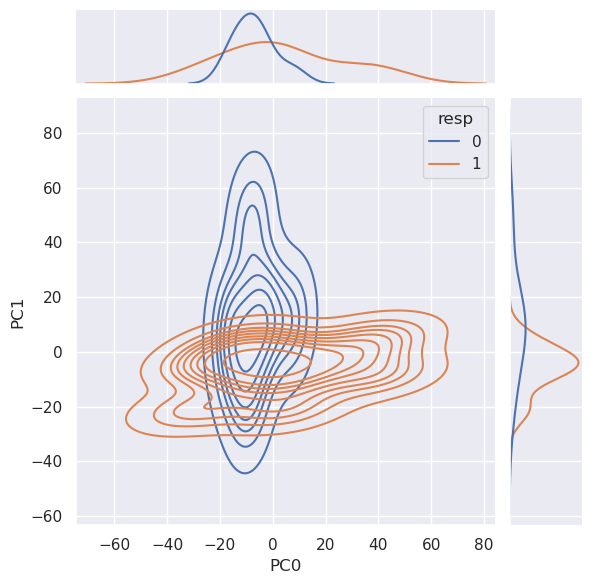

In [491]:
from sklearn.decomposition import PCA

X_embedded = PCA(
    n_components=2,
).fit_transform(X_train)
X_embedded = pd.DataFrame(X_embedded, index=X_train.index, columns=["PC%d" % i for i in range(2)])
df_embedded = pd.concat([X_embedded, y_train],axis=1)

sns.scatterplot(df_embedded, x="PC0", y="PC1", hue="resp")
sns.jointplot(df_embedded, x="PC0", y="PC1", hue="resp", kind="kde")

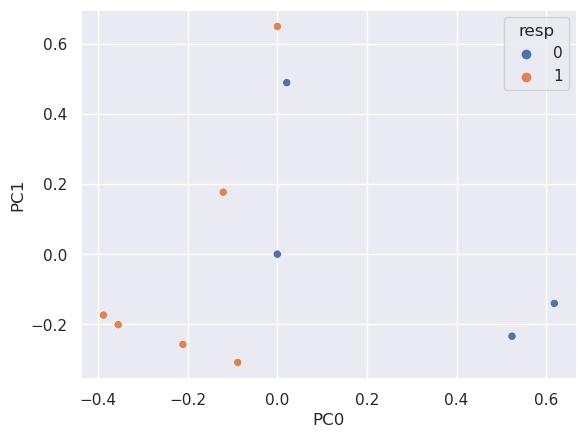

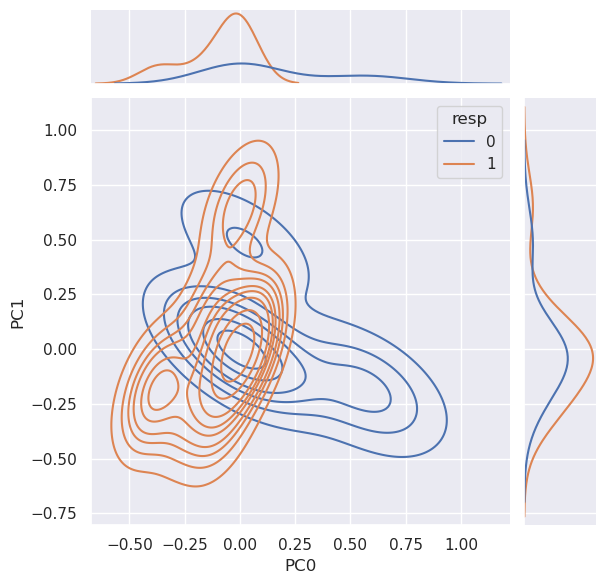

In [519]:
from sklearn.decomposition import KernelPCA

X_embedded = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=1,
    n_jobs=-1
).fit_transform(df_prob)
X_embedded = pd.DataFrame(X_embedded, index=df_prob.index, columns=["PC%d" % i for i in range(2)])
df_embedded = pd.concat([X_embedded, y],axis=1)

sns.scatterplot(df_embedded, x="PC0", y="PC1", hue="respPart")
sns.jointplot(df_embedded, x="PC0", y="PC1", hue="respPart", kind="kde")

## Wrapper methods

In [62]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)

### Forward

### Backward

The Backward feature selection is not time feasible, because we would like to extract up to 20 features over about 1700

### Genetic

In [37]:
from myTransformers import GeneticSelection
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

sss = StratifiedShuffleSplit(n_splits=20, test_size=7)

clf = GradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.05,
    n_estimators=200,
    criterion="friedman_mse",
    max_depth=10,
    max_features=None, # Here I want to consider all the fetures, because the selectio is done by the algorithm
    warm_start=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    # there is even a ccp_alpha parameter, that can be usefull later
)

ga = GeneticSelection(clf, pop_size=100, scoring="roc_auc", cv=sss, n_jobs=-1)
ga.fit(X_train_p, y_train)

Size 100
Generation 0	Score 0.900000	
Selected Features
[[ True  True False False False False False  True  True  True  True  True
   True False False  True False False  True False  True False False  True
  False  True False False  True  True  True  True  True False  True False
   True  True  True False False  True  True False False False False False
  False False False False False  True  True False  True False  True False
   True False  True False  True  True False False  True False  True False
   True False  True  True False  True False  True False  True  True False
  False  True False False False  True False False False False  True False
   True False  True  True False  True False False  True False False False
  False  True False False  True False False False False  True  True False
   True  True False False False  True False False  True  True False False
   True False False False  True  True False  True  True  True False False
   True False False  True  True False  True  True False 

### Recoursive

In [334]:
from sklearn.feature_selection import RFECV
from sklearn import svm


clf = svm.LinearSVC(
    C=1e0,
    class_weight="balanced",
    dual=True
)

rfe = RFECV(
    estimator=clf_lin,
    step=1,
    scoring="roc_auc",
    cv=skf,
    min_features_to_select=2,
    n_jobs=-1
)

rfe.fit(X, y)
print(X.columns[rfe.get_support()].sort_values())


Index(['age', 'epilepsy_duration', 'epilepsy_onset_age',
       'left-accumbens-area_fvf_f1_kurt', 'left-accumbens-area_fvf_f1_skew',
       'left-accumbens-area_fvf_f1_std', 'left-fornix_MD_mean',
       'left-fornix_RD_mean', 'left-hippocampus_fbundle_skew',
       'left-hippocampus_fintra_mean', 'left-hippocampus_fiso_skew',
       'left-thalamus-AntCingCtx_MD_mean',
       'left-thalamus-AntCingCtx_fvf_f1_mean',
       'left-thalamus-AntCingCtx_fvf_f1_std', 'left-thalamus-proper_AD_mean',
       'left-thalamus-proper_MD_mean', 'right-accumbens-area_fvf_f1_kurt',
       'right-accumbens-area_fvf_f1_skew', 'right-amygdala_frac_c0_skew',
       'right-fornix_MD_kurt', 'right-fornix_MD_mean', 'right-fornix_RD_mean',
       'right-fornix_fintra_mean', 'right-fornix_fvf_tot_mean',
       'right-inf-longi-fasci_odi_kurt', 'right-inf-longi-fasci_odi_skew',
       'right-thalamus-Insula_AD_mean', 'right-thalamus-Insula_MD_mean',
       'right-thalamus-Insula_fintra_mean', 'right-thalamus-pr

,rank
age,1
right-accumbens-area_fvf_f1_kurt,1


## Embedded methods

### From model

In [351]:
from sklearn.feature_selection import SelectFromModel

X = df_mean.drop(["resp","respPart"], axis=1)
y = df_mean["resp"]

clf = svm.LinearSVC(
    C=1e-2,
    class_weight="balanced",
    dual=True
)

frModel = SelectFromModel(
    estimator=clf,
    max_features=20,
)

frModel.fit(X, y)
print(X.columns[frModel.get_support()].sort_values())

pd.DataFrame(abs(frModel.estimator_.coef_.T), index=X.columns, columns=["rank"]).sort_values("rank", ascending=False)[:20]

Index(['age', 'epilepsy_duration', 'epilepsy_onset_age',
       'left-accumbens-area_fvf_f1_kurt', 'left-fornix_RD_mean',
       'left-fornix_fextra_std', 'left-inf-longi-fasci_fvf_f0_kurt',
       'right-accumbens-area_fvf_f1_skew', 'right-fornix_RD_mean',
       'right-fornix_fextra_kurt', 'right-fornix_fintra_kurt',
       'right-fornix_fintra_mean', 'right-fornix_fintra_std',
       'right-fornix_frac_c0_std', 'right-fornix_fvf_tot_kurt',
       'right-fornix_fvf_tot_mean', 'right-fornix_fvf_tot_skew',
       'right-fornix_wFA_kurt', 'right-thalamus-Insula_fintra_skew',
       'right-thalamus-proper_fintra_skew'],
      dtype='object')


,rank
epilepsy_onset_age,0.018317
age,0.012354
epilepsy_duration,0.010062
right-thalamus-proper_fintra_skew,0.008841
right-fornix_fintra_mean,0.008535
right-fornix_fvf_tot_kurt,0.007816
right-fornix_fextra_kurt,0.007704
right-thalamus-Insula_fintra_skew,0.007654
right-fornix_fintra_kurt,0.007557
right-fornix_fvf_tot_skew,0.007369


# Model Selection

In this first analysis we consider a binary classification problem. Therefore, we keep the NR-RP/R labels, in which the Partial responders are considered as Responders.

*In next analysis we will consider a multiclass classification problem, trying to classify all the three different types* 

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train, test in skf.split(X, y):
    print("%s %s" % (train, test))

[ 0  2  3  5  7  8  9 10 12 13 14 15 16 17 18] [ 1  4  6 11]
[ 0  1  2  4  6  7  8  9 10 11 12 14 16 17 18] [ 3  5 13 15]
[ 0  1  2  3  4  5  6  9 10 11 12 13 15 16 18] [ 7  8 14 17]
[ 0  1  2  3  4  5  6  7  8 11 13 14 15 17 18] [ 9 10 12 16]
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [ 0  2 18]


In [37]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
for train, test in rskf.split(X, y):
    print("%s %s" % (train, test))

[ 3  4  5  6  7  8  9 11 12 13 14 15 16 17 18] [ 0  1  2 10]
[ 0  1  2  4  5  6  7  8 10 11 13 14 15 16 17] [ 3  9 12 18]
[ 0  1  2  3  4  5  7  8  9 10 11 12 15 17 18] [ 6 13 14 16]
[ 0  1  2  3  6  7  8  9 10 12 13 14 16 17 18] [ 4  5 11 15]
[ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 18] [ 7  8 17]
[ 0  1  2  4  5  6  8  9 10 12 13 14 15 17 18] [ 3  7 11 16]
[ 1  2  3  4  6  7  8  9 10 11 12 15 16 17 18] [ 0  5 13 14]
[ 0  1  3  4  5  7  8  9 11 12 13 14 15 16 17] [ 2  6 10 18]
[ 0  2  3  5  6  7  8 10 11 12 13 14 15 16 18] [ 1  4  9 17]
[ 0  1  2  3  4  5  6  7  9 10 11 13 14 16 17 18] [ 8 12 15]


In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=20, test_size=5)
for train, test in sss.split(X, y):
    print("%s %s" % (train, test))

[14 11 16  6  8 10  5  9 13  4 15  2 12  1] [ 3 17 18  7  0]
[13 12 14  9 17 16  6  8 10  0 18  3 11  1] [ 5  4  2 15  7]
[ 7  0 17 11 15  3  2  1  5 10 16  4  6 13] [18  8  9 14 12]
[15  8 17 18  1  5  9 10  6  4  7 13 11  2] [12 16 14  3  0]
[10 13 12  8  3  0 11 17 15  2 14  7 16  5] [ 9  6 18  1  4]
[ 1 12  8 14 11 13  9 18 15 16  4  7  2  5] [10  6 17  3  0]
[ 0  6 18  3 11 10 15 13  7  9 17 12 16  5] [ 4  8  2 14  1]
[ 1  0  8 10  2  4  5  9  6 15 13 17 14 11] [ 7 16 18 12  3]
[13 14 15  2 17  7 12  1  8 16  6  3 18  0] [10 11  4  5  9]
[ 3  5  9 12  0 15 16 10 13  6  1  8 18  4] [ 7 14 17 11  2]
[ 4 15  3  2 14  6 10  8 11  7  5 18  1  9] [13  0 17 16 12]
[ 6 13  1 16 10  0 12 18 11 14  7 17  8  2] [ 4  9 15  3  5]
[16  5 10  8 18  3  6  4  1  2 12 17 13 11] [ 7  9 14  0 15]
[ 9 11 13  6 16  5  0  1 10 15  7 14 17  8] [ 3 12  2 18  4]
[18 11 13  6  5  3 12  1 16 17 15  7  0 10] [ 4  8  2 14  9]
[ 4  1 13 12 11 18  6  2  3 17 15  9 14  0] [ 5  7  8 16 10]
[11  2 16 13  5  6  9 17

In [376]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

y = df["resp"]
X = df.drop(["resp", "respPart"], axis=1) 

models = {
    "linearSVM" : (
        LinearSVC(), 
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__C" : (1e-3, 1e-2, 1e-1),
        }
    ),
    "SVM" : (
        SVC(),
        [
            {
                "selection__k" : (2, 3, 5, 7, 9),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['linear'], 
            },
            {
                "selection__k" : (2, 3, 5, 7, 9),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['poly'],
                "classifier__degree" : (2, 3, 4),
            },
            {
                "selection__k" : (2, 3, 5, 7, 9),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['rbf'], 
                "classifier__gamma" : (1e-3, 1e-2, 1e-1, 1),
            },
        ]
    ),
    "LogReg" : (
        LogisticRegression(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__penalty" : ["l2"],
            "classifier__dual" : [True],
            "classifier__C" :(1e-3, 1e-2, 1e-1),
        },
    ),
    "LinReg" : (
        LinearRegression(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
        }
    ),
    "ridgeReg" : (
        RidgeClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__alpha" : (0.5, 1, 5, 10, 20, 40)
        }
    ),
    "elasticNet" : (
        ElasticNet(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__alpha" : (0.5, 1, 5, 10, 20, 40),  # 0 == Linear Regression
            "classifier__l1_ratio" : (0.5, 1), # 0 == Ridge Regression, 1 == Lasso Regression
        },
    ),
    "neighbors" : (
        KNeighborsClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__n_neighbors" : (2, 3, 5),
            "classifier__weights" : ("uniform", "distance"),
        }
    ),
    "gaussianNaive" : (
        GaussianNB(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19, 21),
        }
    ),
    "tree" : (
        DecisionTreeClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__criterion" : ("gini", "entropy", "log_loss")
        }
    ),
    "forest" : (
        RandomForestClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__max_samples" : [0.5]
        }
    ),
    "extraForest" : (
        ExtraTreesClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__bootstrap" : [True],
            "classifier__max_samples" : [0.5],
        }
    ),
    "adaBoost" : (
        AdaBoostClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 1000),
        }
    )
}

skf = StratifiedKFold(n_splits=5, shuffle=True)

fitted_models = {}

for modelName, (classifier, grid) in models.items():

    pre = ColumnTransformer(
            [("scaling", RobustScaler(), col_cont)],
            remainder="passthrough", # one hot or other stuff
        )
    
    thresh = VarianceThreshold()
    
    imputer = SimpleImputer(
            missing_values=np.nan, 
            strategy="mean"
        )
    
    selection = SelectKBest(
            score_func=mutual_info_classif,
        )
    
    pipe = Pipeline([
        ("pre", pre),
        ("varThres", thresh),
        ("imputer", imputer),
        ("selection", selection),
        ("classifier", classifier)
    ])

    model = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="roc_auc",
        n_jobs=-1,
        cv=skf,
        verbose=3
    )

    model.fit(X, y)
    fitted_models[modelName] = model

    print(modelName, "score:", model.best_score_)
    print(model.best_params_) 

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END classifier__C=0.001, selection__k=2;, score=0.333 total time=   5.5s
[CV 4/5] END classifier__C=0.001, selection__k=2;, score=0.500 total time=   5.4s
[CV 1/5] END classifier__C=0.001, selection__k=3;, score=0.333 total time=   5.8s
[CV 3/5] END classifier__C=0.001, selection__k=3;, score=0.000 total time=   5.5s
[CV 3/5] END classifier__C=0.001, selection__k=2;, score=0.250 total time=   6.0s
[CV 5/5] END classifier__C=0.001, selection__k=2;, score=0.000 total time=   5.9s
[CV 2/5] END classifier__C=0.001, selection__k=3;, score=0.000 total time=   5.5s
[CV 2/5] END classifier__C=0.001, selection__k=2;, score=0.000 total time=   6.3s
[CV 4/5] END classifier__C=0.001, selection__k=3;, score=0.500 total time=   6.3s
[CV 2/5] END classifier__C=0.001, selection__k=5;, score=0.333 total time=   5.6s
[CV 5/5] END classifier__C=0.001, selection__k=3;, score=0.000 total time=   6.5s
[CV 1/5] END classifier__C=0.001, se

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END classifier__C=100.0, selection__k=2;, score=0.000 total time=   5.9s
[CV 5/5] END classifier__C=10.0, selection__k=9;, score=0.000 total time=   6.4s
[CV 3/5] END classifier__C=100.0, selection__k=2;, score=0.000 total time=   6.3s
[CV 1/5] END classifier__C=100.0, selection__k=2;, score=0.333 total time=   7.4s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=100.0, selection__k=2;, score=1.000 total time=   6.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END classifier__C=100.0, selection__k=2;, score=0.000 total time=   6.7s
[CV 1/5] END classifier__C=100.0, selection__k=3;, score=0.333 total time=   6.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END classifier__C=100.0, selection__k=3;, score=0.000 total time=   7.1s
[CV 3/5] END classifier__C=100.0, selection__k=3;, score=0.500 total time=   6.8s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=100.0, selection__k=3;, score=0.500 total time=   7.1s
[CV 1/5] END classifier__C=100.0, selection__k=5;, score=0.333 total time=   6.6s
[CV 2/5] END classifier__C=100.0, selection__k=5;, score=0.000 total time=   6.4s
[CV 5/5] END classifier__C=100.0, selection__k=3;, score=0.000 total time=   7.2s
[CV 3/5] END classifier__C=100.0, selection__k=5;, score=0.500 total time=   7.0s
[CV 4/5] END classifier__C=100.0, selection__k=5;, score=0.500 total time=   6.7s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END classifier__C=100.0, selection__k=5;, score=0.000 total time=   7.2s
[CV 3/5] END classifier__C=100.0, selection__k=7;, score=0.250 total time=   6.0s
[CV 2/5] END classifier__C=100.0, selection__k=7;, score=0.000 total time=   7.0s
[CV 1/5] END classifier__C=100.0, selection__k=7;, score=0.333 total time=   7.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=100.0, selection__k=7;, score=0.500 total time=   7.1s
[CV 5/5] END classifier__C=100.0, selection__k=7;, score=0.500 total time=   7.4s
[CV 2/5] END classifier__C=100.0, selection__k=9;, score=0.000 total time=   6.7s
[CV 1/5] END classifier__C=100.0, selection__k=9;, score=0.667 total time=   7.6s
[CV 3/5] END classifier__C=100.0, selection__k=9;, score=0.250 total time=   6.7s
[CV 1/5] END classifier__C=1000.0, selection__k=2;, score=0.333 total time=   5.8s
[CV 4/5] END classifier__C=100.0, selection__k=9;, score=0.500 total time=   7.0s
[CV 5/5] END classifier__C=100.0, selection__k=9;, score=0.000 total time=   7.0s
[CV 2/5] END classifier__C=1000.0, selection__k=2;, score=0.000 total time=   7.9s
[CV 3/5] END classifier__C=1000.0, selection__k=2;, score=0.250 total time=   7.4s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=1000.0, selection__k=2;, score=0.500 total time=   6.7s
[CV 2/5] END classifier__C=1000.0, selection__k=3;, score=0.000 total time=   5.9s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END classifier__C=1000.0, selection__k=2;, score=0.000 total time=   7.2s
[CV 1/5] END classifier__C=1000.0, selection__k=3;, score=0.333 total time=   7.5s
[CV 3/5] END classifier__C=1000.0, selection__k=3;, score=0.000 total time=   6.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=1000.0, selection__k=3;, score=0.500 total time=   6.7s
[CV 1/5] END classifier__C=1000.0, selection__k=5;, score=0.333 total time=   6.6s
[CV 5/5] END classifier__C=1000.0, selection__k=3;, score=0.000 total time=   7.3s
[CV 2/5] END classifier__C=1000.0, selection__k=5;, score=0.000 total time=   6.1s
[CV 3/5] END classifier__C=1000.0, selection__k=5;, score=0.250 total time=   6.0s
[CV 4/5] END classifier__C=1000.0, selection__k=5;, score=0.000 total time=   6.3s
[CV 1/5] END classifier__C=1000.0, selection__k=7;, score=0.667 total time=   6.5s
[CV 5/5] END classifier__C=1000.0, selection__k=5;, score=0.000 total time=   6.6s
[CV 2/5] END classifier__C=1000.0, selection__k=7;, score=0.333 total time=   6.7s
[CV 3/5] END classifier__C=1000.0, selection__k=7;, score=0.500 total time=   6.5s
[CV 4/5] END classifier__C=1000.0, selection__k=7;, score=0.500 total time=   6.4s
[CV 5/5] END classifier__C=1000.0, selection__k=7;, score=0.000 total time=   6.3s
[CV 

KeyboardInterrupt: 